## Pareto + RandomForest 帕累托最优

In [32]:
import time
import pandas as pd
import numpy as np

d1 = pd.read_csv("data/材料1.csv")
d2 = pd.read_csv("data/材料2.csv")
d3 = pd.read_csv("data/材料3.csv")
d4 = pd.read_csv("data/材料4.csv")

d1['材料'] = 1
d2['材料'] = 2
d3['材料'] = 3
d4['材料'] = 4

pd.set_option('future.no_silent_downcasting', True)

data = pd.concat([d1, d2, d3, d4])
data['励磁波形'] = data['励磁波形'].replace({'正弦波': 1, '三角波': 2, '梯形波': 3})

B_ = data.iloc[:, 4:-1].values

lst = ['温度', '频率', "磁芯损耗", '励磁波形']
for i in range(1024):
    lst.append(i)
lst.append('材料')
data.columns = lst

# std_flux = np.std(magnetic_flux_density, axis=1)  # 标准差
max_flux = np.max(B_, axis=1)  # 峰值
min_flux = np.min(B_, axis=1)

data['B_max'] = max_flux
data['B_min'] = min_flux

filter_data = data[
    ['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min', '磁芯损耗']
]

# to = pd.DataFrame(filter_data)
# to.to_csv("~/Desktop/data.csv", index=False)
filter_data.head()

,温度,频率,励磁波形,材料,B_max,B_min,磁芯损耗
0,25,50030,1,1,0.028849,-0.028840,1997.955250
1,25,50020,1,1,0.031419,-0.031427,2427.749830
2,25,50020,1,1,0.035535,-0.035513,3332.725760
3,25,50020,1,1,0.040015,-0.040025,4502.908007
4,25,50030,1,1,0.045028,-0.045085,6063.023248


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

start_time = time.time()
X = data[['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min']]  # 自变量 
y = data['磁芯损耗']  # 因变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ExtraTreesRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
end_time = time.time()

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)

print(f"mape: {mape:.2f}, mse: {mse:.2f}")

mape: 9.16, mse: 1365179387.41


In [34]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import *
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
import matplotlib.pyplot as plt

temperature_values = np.array([25, 50, 70, 90])
waveform_values = np.array([1, 2, 3])
material_values = np.array([1, 2, 3, 4])

lb = np.array([25, 50000, 1, 1, 0.01, -0.1])
ub = np.array([90, 500000, 3, 4, 0.1, -0.01])

# 定义优化问题的目标函数
def evaluate(individual):
    # 将个体 (萤火虫) 的参数值映射为实际的决策变量
    temp, freq, waveform, material, B_max, B_min = individual
    
    # 创建 DataFrame 以便调用 model_predict
    X = pd.DataFrame([individual], columns=['温度', '频率', '励磁波形', '材料', 'B_max', 'B_min'])
    
    # 调用模型来预测磁芯损耗
    core_loss = model.predict(X)[0]  # f1：最小化磁芯损耗
    
    # 传输磁能计算公式 f2：最大化传输磁能
    transmitted_energy = B_max * freq
    
    return core_loss, transmitted_energy


In [35]:
import random
start = time.time()


# 非支配排序函数，用于判定解集中的非支配解
def dominates(f1, f2):
    not_worse = all(a <= b for a, b in zip(f1, f2))
    strictly_better = any(a < b for a, b in zip(f1, f2))
    return not_worse and strictly_better

def get_pareto_front(population):
    pareto_front = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if i != j and dominates(ind2[1], ind1[1]):  # ind1 被 ind2 支配
                dominated = True
                break
        if not dominated:
            pareto_front.append(ind1)
    return pareto_front

# 更新萤火虫位置的函数
def update_position(firefly, brighter_firefly, beta, alpha, gamma):
    distance = np.linalg.norm(np.array(firefly) - np.array(brighter_firefly))
    attractiveness = beta * np.exp(-gamma * distance**2)
    random_factor = alpha * (random.random() - 0.5)
    return firefly + attractiveness * (np.array(brighter_firefly) - np.array(firefly)) + random_factor

# 初始化种群
def initialize_population(pop_size, lower_bound, upper_bound, n_variables):
    population = []
    for _ in range(pop_size):
        individual = [random.uniform(lower_bound[i], upper_bound[i]) for i in range(n_variables)]
        fitness = evaluate(individual)
        population.append((individual, fitness))
    return population

# 萤火虫算法参数
pop_size = 100
n_gen = 100
alpha = 0.2  # 随机因素
beta = 1.0   # 吸引力
gamma = 1.0  # 吸引力随距离的衰减
lower_bound = [25, 50000, 1, 1, 0.01, -0.1]  # 决策变量的下界
upper_bound = [90, 500000, 3, 4, 0.1, -0.01]  # 决策变量的上界

# 初始化种群
population = initialize_population(pop_size, lower_bound, upper_bound, 6)

# 运行多目标萤火虫算法
for gen in range(n_gen):
    new_population = []
    pareto_front = get_pareto_front(population)
    for i, (ind, fit) in enumerate(population):
        for pareto_ind, pareto_fit in pareto_front:
            if dominates(pareto_fit, fit):  # 如果 Pareto 前沿上的解支配当前解
                ind = update_position(ind, pareto_ind, beta, alpha, gamma)
                fit = evaluate(ind)
        new_population.append((ind, fit))
    population = new_population
    print(f"Generation {gen+1}/{n_gen}, Pareto front size: {len(pareto_front)}")

# 提取 Pareto 最优解
pareto_front = get_pareto_front(population)
pareto_solutions = np.array([ind for ind, fit in pareto_front])
pareto_fitness = np.array([fit for ind, fit in pareto_front])

end = time.time()
print("Time: ", start - end)


Generation 1/100, Pareto front size: 2
Generation 2/100, Pareto front size: 9
Generation 3/100, Pareto front size: 17
Generation 4/100, Pareto front size: 23
Generation 5/100, Pareto front size: 22
Generation 6/100, Pareto front size: 27
Generation 7/100, Pareto front size: 25
Generation 8/100, Pareto front size: 29
Generation 9/100, Pareto front size: 31
Generation 10/100, Pareto front size: 37
Generation 11/100, Pareto front size: 42
Generation 12/100, Pareto front size: 44
Generation 13/100, Pareto front size: 47
Generation 14/100, Pareto front size: 43
Generation 15/100, Pareto front size: 45
Generation 16/100, Pareto front size: 45
Generation 17/100, Pareto front size: 49
Generation 18/100, Pareto front size: 53
Generation 19/100, Pareto front size: 52
Generation 20/100, Pareto front size: 53
Generation 21/100, Pareto front size: 56
Generation 22/100, Pareto front size: 61
Generation 23/100, Pareto front size: 64
Generation 24/100, Pareto front size: 60
Generation 25/100, Pareto f

In [36]:
# 从 Pareto 最优解中选择磁芯损耗最小的解
min_core_loss_index = np.argmin(pareto_fitness[:, 0])
best_solution = pareto_solutions[min_core_loss_index]
best_fitness = pareto_fitness[min_core_loss_index]

print("最佳解（磁芯损耗最小）：")
print(f"决策变量：{best_solution}")
print(f"磁芯损耗：{best_fitness[0]}")
print(f"传输磁能：{best_fitness[1]}")

最佳解（磁芯损耗最小）：
决策变量：[ 7.97624013e+01  6.83293856e+04  2.88922422e+00  3.27076820e+00
  1.61862970e-02 -3.52450811e-02]
磁芯损耗：2110.9340149723967
传输磁能：1105.9997290186511


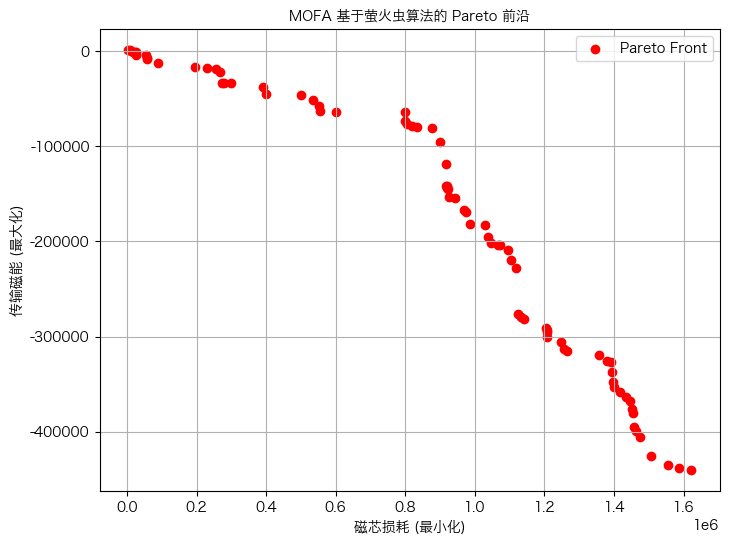

In [37]:
from matplotlib import font_manager

# 可视化Pareto前沿
font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc'
my_font = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# 绘制 Pareto 前沿
plt.figure(figsize=(8, 6))
plt.scatter(pareto_fitness[:, 0], pareto_fitness[:, 1], color='red', label="Pareto Front")
plt.xlabel("磁芯损耗 (最小化)", fontproperties=my_font)
plt.ylabel("传输磁能 (最大化)", fontproperties=my_font)
plt.title("MOFA 基于萤火虫算法的 Pareto 前沿", fontproperties=my_font)
plt.grid(True)
plt.legend(prop=my_font)
plt.show()

# plt.figure(figsize=(8, 6))
# plt.scatter(pareto_solutions[:, 0], -pareto_solutions[:, 1], color='red', label="Pareto前沿")
# plt.xlabel("磁芯损耗（最小化）", fontproperties=my_font)
# plt.ylabel("传输磁能（最大化）", fontproperties=my_font)
# plt.title("Pareto 前沿 - 磁芯损耗 vs 传输磁能", fontproperties=my_font)
# plt.legend(prop=my_font)
# plt.grid(True)
# plt.show()